# Task Overview

In this task, your goal is to verify the impact of data noise level in neural network training.
You should use MLP architecture trained on MNIST dataset (like in previous lab exercises).


We will experiment with two setups:
1. Pick X. Take X% of training examples and reassign their labels to random ones. Note that we don't change anything in the test set.
2. Pick X. During each training step, for each sample, change values of X% randomly selected pixels to random values. Note that we don't change anything in the test set.

For both setups, check the impact of various levels of noise (various values of X%) on model performance. Show plots comparing crossentropy (log-loss) and accuracy with varying X%, and also comparing two setups with each other.
Prepare short report briefly explaining the results and observed trends. Consider questions like "why accuracy/loss increases/decreases so quickly/slowly", "why Z is higher in setup 1/2" and any potentially surprising things you see on charts.

### Potential questions, clarifications
* Q: Can I still use sigmoid/MSE loss?
  * You should train your network with softmax and crossentropy loss (log-loss), especially since you should report crossentropy loss.
* Q: When I pick X% of pixels/examples, does it have to be exactly X% or can it be X% in expectation?
  * A: It's fine either way.
* Q: When I randomize pixels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Each training step/epoch.
* Q: When I randomize labels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Only once before training.
* Q: What is the expected length of report/explanation?
  * A: There is no minimum/maximum, but between 5 (concise) and 20 sentences should be good. Don't forget about plots.
* Q: When I replace labels/pixels with random values, what random distribution should I use?
  * A: A distribution reasonably similar to the data. However, you don't need to match dataset's distribution exactly - approximation will be totally fine, especially if it's faster or easier to get.
* Q: Can I use something different than Colab/Jupyter Notebook? E.g. just Python files.
  * A: Yes, although notebook is encouraged; please include in you solution code and pdf.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

# Model definition and training.

In [2]:
class Net(nn.Module):
    def __init__(self, sizes):
        super(Net, self).__init__()
        # After flattening an image of size 28x28 we have 784 inputs
        self.linears = nn.ModuleList([nn.Linear(a, b) for a, b in zip(sizes, sizes[1:])])

    def forward(self, x):
        x = torch.flatten(x, 1)
        for i, l in enumerate(self.linears[:-1]):
            x = l(x)
            x = F.relu(x)
        x = self.linears[-1](x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return sum(losses) / len(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, float(correct) / len(test_loader.dataset)

In [3]:
batch_size = 256
test_batch_size = 1000
epochs = 5
lr = 1e-2
use_cuda = False
seed = 1
log_interval = 10

In [4]:
use_cuda = not use_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313259
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.732760
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.582762
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.481087
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.334523
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.346265
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.229349
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.191099
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.224889
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.244065
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.236049
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.241033
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.194209
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.302404
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.203934
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.192445
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.173173
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.140804
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.356528
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.130329
Train Epoc

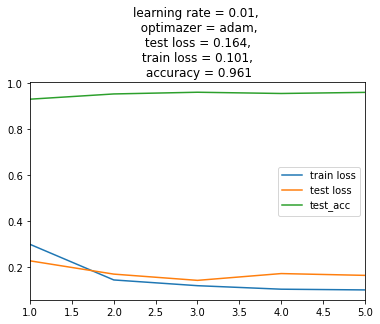

In [6]:
model = Net([784, 128, 128, 10]).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
test_losses = []
test_accs = []

for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, log_interval)
    test_loss, test_acc = test(model, device, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)


xs = range(1, len(train_losses) + 1)
plt.clf()
plt.xlim(1, epoch)
plt.plot(xs, train_losses, label='train loss')
plt.plot(xs, test_losses, label='test loss')
plt.plot(xs, test_accs, label='test_acc')
plt.title('\n'.join([f'learning rate = {lr}, \n  optimazer = adam, \n test loss = {test_loss:.3f}, \n train loss = {train_loss:.3f}, \n accuracy = {test_acc:.3f}',]))
plt.legend()
plt.show()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297579
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.207315
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.945172
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.472798
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.791390
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.726202
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.448863
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.367503
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.456898
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.390381
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.347748
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.459875
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.422484
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.379510
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.347917
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.355125
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.297552
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.270517
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.423848
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.183994
Train Epoc

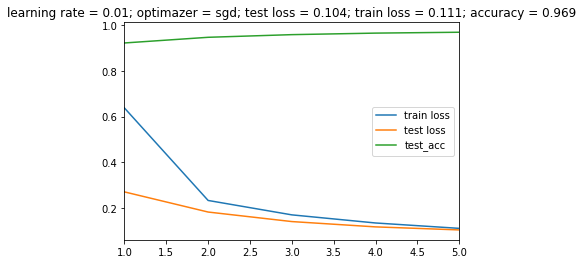

In [7]:
model = Net([784, 128, 128, 10]).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

train_losses = []
test_losses = []
test_accs = []

for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, log_interval)
    test_loss, test_acc = test(model, device, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

xs = range(1, len(train_losses) + 1)
plt.clf()
plt.xlim(1, epoch)
plt.plot(xs, train_losses, label='train loss')
plt.plot(xs, test_losses, label='test loss')
plt.plot(xs, test_accs, label='test_acc')
plt.title('\n'.join([f'learning rate = {lr}; optimazer = sgd; test loss = {test_loss:.3f}; train loss = {train_loss:.3f}; accuracy = {test_acc:.3f}',]))
plt.legend()
plt.show()

# Training models in setup 1: with randomized labels.

In [8]:
def dataset_with_random_target(percent_of_change):
  dataset_to_change = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
  length_of_dataset = len(dataset_to_change)
  quantity = int(length_of_dataset * percent_of_change)
  indexes = random.sample(range(length_of_dataset), quantity)
  classes_before_change = dataset_to_change.targets.tolist()
  current_distribution = (torch.bincount(dataset_to_change.targets)/length_of_dataset).tolist()
  classes = list(range(10))
  for i in indexes:
    current_class = dataset_to_change.targets[i].item()
    new_class = current_class
    while current_class == new_class:
      new_class = np.random.choice(classes, p=current_distribution)
    new_class = torch.tensor(new_class)
    dataset_to_change.targets[i] = new_class
  classes_after_change = dataset_to_change.targets.tolist()
  return dataset_to_change

In [9]:
percentes = np.arange(0.05, 1, 0.05).round(2).tolist()
adam_results = {}
for percent in percentes:
  print(percent)
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
  dataset_train = dataset_with_random_target(percent)
  dataset_test = datasets.MNIST('../data', train=False, transform=transform)
  train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)
  test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

  model = Net([784, 128, 128, 10]).to(device)
  optimizer_name = 'adam'
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  test_losses = []
  test_accs = []

  for epoch in range(1, epochs + 1):
      train_loss = train(model, device, train_loader, optimizer, epoch, log_interval)
      test_loss, test_acc = test(model, device, test_loader)

      train_losses.append(train_loss)
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  adam_results[percent] = [train_losses, test_losses, test_accs]

0.05
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301367
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.027136
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.784028
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.830135
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.607846
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.680643
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.517558
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.417901
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.652871
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.741625
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.547726
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.564970
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.461884
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.659484
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.514958
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.407164
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.547800
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.362957
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.557294
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.372707
Train

In [10]:
print(adam_results)

{0.05: [[0.6128878180016862, 0.48226065064998386, 0.4546502084174055, 0.43114158720412155, 0.42347132145090305], [0.26873645629882814, 0.244024405670166, 0.19474739532470703, 0.18706613922119142, 0.18367025604248047], [0.9321, 0.9369, 0.953, 0.9521, 0.9561]], 0.1: [[0.851590452422487, 0.7210596036403737, 0.6944179475307465, 0.6768141268415654, 0.6619102582018426], [0.2846975158691406, 0.25755379486083985, 0.25899597625732423, 0.2474038299560547, 0.24593474884033203], [0.9429, 0.9498, 0.949, 0.9524, 0.9514]], 0.15: [[1.0406597938943416, 0.9234384714288915, 0.8913594096264941, 0.8769547503045265, 0.8691916957814643], [0.38244059448242185, 0.34450697631835936, 0.3154251037597656, 0.33769997711181643, 0.3580802947998047], [0.9349, 0.9467, 0.9517, 0.9518, 0.9487]], 0.2: [[1.2136594975248296, 1.105489055653836, 1.0770610687580515, 1.0611738369819965, 1.049040422287393], [0.513715805053711, 0.434414501953125, 0.41193075256347655, 0.3776139190673828, 0.3794037048339844], [0.9252, 0.9407, 0.938

In [11]:
percentes = np.arange(0.05, 1, 0.05).round(2).tolist()
sgd_results = {}
for percent in percentes:
  print(percent)
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
  dataset_train = dataset_with_random_target(percent)
  dataset_test = datasets.MNIST('../data', train=False, transform=transform)
  train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)
  test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

  model = Net([784, 128, 128, 10]).to(device)
  optimizer_name = 'sgd'
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


  train_losses = []
  test_losses = []
  test_accs = []

  for epoch in range(1, epochs + 1):
      train_loss = train(model, device, train_loader, optimizer, epoch, log_interval)
      test_loss, test_acc = test(model, device, test_loader)

      train_losses.append(train_loss)
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  sgd_results[percent] = [train_losses, test_losses, test_accs]

0.05
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300828
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.197249
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.927519
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.471809
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.977314
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.012805
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.640112
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.713708
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.664233
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.673351
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.580639
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.820393
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.716547
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.587433
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.850990
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.508508
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.555590
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.576049
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.728099
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.482148
Train

# Training models in setup 2: with randomized pixels.

In [12]:
# train set distribution
dataset_train = datasets.MNIST('../data', train=True, download=True, 
                               transform=transforms.Compose([
                                                             transforms.ToTensor(),
                                                             transforms.Normalize((0.1307,), (0.3081,))
                                                             ]))
values = [0] * 256
for i in range(len(dataset_train.data)):
  for j in range(len(dataset_train.data[i])):
    for k in range(len(dataset_train.data[i][j])):
      values[int(dataset_train.data[i][j][k])] += 1

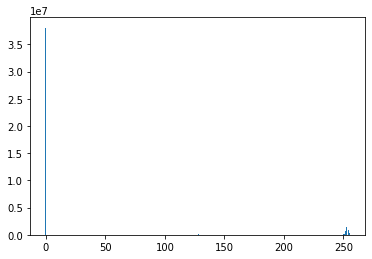

In [13]:
indexes = np.arange(len(values))
plt.bar(indexes, values)
plt.show()

We'll simplify distribution -- we will take into consideration probability of getting 0 and 255. 

In [14]:
prob_0 = sum(values[:200])/sum(values)
prob_1 = sum(values[200:])/sum(values)
prob_0, prob_1

(0.8976576530612245, 0.10234234693877552)

In [15]:
class AddNoise(object):
    def __init__(self, percent, distribution):
        self.percent = percent
        self.distribution = distribution
        
    def __call__(self, tensor):
        # version 1 (slower):
        #   classes = list(range(256))
        #   mask = create_mask(tensor.size(),percent) < percent
        #   tensor[mask==False] = np.random.choice(classes, p=distribution)
        #   return tensor
        # version 2 (faster):
        mask = torch.distributions.categorical.Categorical(torch.tensor([self.percent, 1 - self.percent])).sample(tensor.size())
        return tensor * mask + (1 - mask) * torch.distributions.categorical.Categorical(torch.tensor([self.distribution, 1 - self.distribution])).sample(tensor.size())

    def __repr__(self):
        return self.__class__.__name__ + '(percent = {0})'.format(self.percent)

In [16]:
percentes = np.arange(0.1, 1, 0.1).round(2).tolist()
distribution = [x / sum(values) for x in values]
adam_results_matrix = {}
for percent in percentes:
  print(percent)
  transform_with_noise=transforms.Compose([
    transforms.ToTensor(),
    AddNoise(percent, prob_1),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
  
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
  dataset_train = datasets.MNIST('../data', train=True, download=True, transform=transform_with_noise)
  dataset_test = datasets.MNIST('../data', train=False, transform=transform)
  train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)
  test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

  model = Net([784, 128, 128, 10]).to(device)
  optimizer_name = 'adam'
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  test_losses = []
  test_accs = []

  for epoch in range(1, epochs + 1):
      train_loss = train(model, device, train_loader, optimizer, epoch, log_interval)
      test_loss, test_acc = test(model, device, test_loader)

      train_losses.append(train_loss)
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  adam_results_matrix[percent] = [train_losses, test_losses, test_accs]

0.1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301675
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.638932
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.461242
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.503045
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.442315
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.439828
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.292745
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.233054
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.272633
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.343940
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.335928
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.384824
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.279316
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.321463
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.268992
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.311637
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.234558
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.157648
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.403137
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.236614
Train 

In [17]:
percentes = np.arange(0.1, 1, 0.1).round(2).tolist()
distribution = [x / sum(values) for x in values]
sgd_results_matrix = {}
for percent in percentes:
  print(percent)
  transform_with_noise=transforms.Compose([
    transforms.ToTensor(),
    AddNoise(percent, prob_1),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
  
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
  dataset_train = datasets.MNIST('../data', train=True, download=True, transform=transform_with_noise)
  dataset_test = datasets.MNIST('../data', train=False, transform=transform)
  train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)
  test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

  model = Net([784, 128, 128, 10]).to(device)
  optimizer_name = 'sgd'
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  train_losses = []
  test_losses = []
  test_accs = []

  for epoch in range(1, epochs + 1):
      train_loss = train(model, device, train_loader, optimizer, epoch, log_interval)
      test_loss, test_acc = test(model, device, test_loader)

      train_losses.append(train_loss)
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  sgd_results_matrix[percent] = [train_losses, test_losses, test_accs]

0.1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301848
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241279
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.051156
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.717726
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.066682
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.859786
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.590350
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.456941
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.529408
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.436246
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.413585
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.545420
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.525376
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.454785
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.474568
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.496782
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.438335
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.308661
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.504864
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.329386
Train 

# Plots and report.

In [37]:
import plotly.express as px
from plotly.subplots import make_subplots

In [24]:
adam_res = pd.DataFrame.from_dict(adam_results, orient='index', columns=['train_loss', 'test_loss', 'test_acc'])
sgd_res = pd.DataFrame.from_dict(sgd_results, orient='index', columns=['train_loss', 'test_loss', 'test_acc'])
adam_res_mat = pd.DataFrame.from_dict(adam_results_matrix, orient='index', columns=['train_loss', 'test_loss', 'test_acc'])
sgd_res_mat = pd.DataFrame.from_dict(sgd_results_matrix, orient='index', columns=['train_loss', 'test_loss', 'test_acc'])

In [54]:
train_loss_adam = adam_res['train_loss']
test_loss_adam = adam_res['test_loss']
test_acc_adam = adam_res['test_acc']

In [53]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))
for index, row in train_loss_adam.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=1)

for index, row in test_loss_adam.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=2)

for index, row in test_acc_adam.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=3)


fig.update_layout(showlegend=False, title_text="Change of labels with ADAM optimizer")
fig.show()

In [55]:
train_loss_sgd = sgd_res['train_loss']
test_loss_sgd = sgd_res['test_loss']
test_acc_sgd = sgd_res['test_acc']

In [56]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))
for index, row in train_loss_sgd.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=1)

for index, row in test_loss_sgd.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=2)

for index, row in test_acc_sgd.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=3)


fig.update_layout(showlegend=False, title_text="Change of labels with SGD optimizer (momentum = 0.9)")
fig.show()

In [57]:
train_loss_adam_mat = adam_res_mat['train_loss']
test_loss_adam_mat = adam_res_mat['test_loss']
test_acc_adam_mat = adam_res_mat['test_acc']

In [58]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))
for index, row in train_loss_adam_mat.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=1)

for index, row in test_loss_adam_mat.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=2)

for index, row in test_acc_adam_mat.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=3)


fig.update_layout(showlegend=False, title_text="Change of pixels with ADAM optimizer")
fig.show()

In [59]:
train_loss_sgd_mat = sgd_res_mat['train_loss']
test_loss_sgd_mat = sgd_res_mat['test_loss']
test_acc_sgd_mat = sgd_res_mat['test_acc']

In [61]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))
for index, row in train_loss_sgd_mat.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=1)

for index, row in test_loss_sgd_mat.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=2)

for index, row in test_acc_sgd_mat.items():
  fig.add_trace(go.Scatter(y=row, mode="lines", hovertext=f'% of change: {index}'), row=1, col=3)


fig.update_layout(showlegend=False, title_text="Change of pixels with SGD optimizer (momentum = 0.9)")
fig.show()

In [76]:
indexes = percentes
idx = 0.1

fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))

fig.add_trace(go.Scatter(y=train_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=1)

fig.add_trace(go.Scatter(y=test_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=2)

fig.add_trace(go.Scatter(y=test_acc_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=3)

fig.update_layout(showlegend=False, title_text=f"Change of values for train loss, test loss and test accuracy for {idx}% of change")
fig.show()

In [77]:
indexes = percentes
idx = 0.2

fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))

fig.add_trace(go.Scatter(y=train_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=1)

fig.add_trace(go.Scatter(y=test_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=2)

fig.add_trace(go.Scatter(y=test_acc_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=3)

fig.update_layout(showlegend=False, title_text=f"Change of values for train loss, test loss and test accuracy for {idx}% of change")
fig.show()

In [78]:
indexes = percentes
idx = 0.3

fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))

fig.add_trace(go.Scatter(y=train_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=1)

fig.add_trace(go.Scatter(y=test_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=2)

fig.add_trace(go.Scatter(y=test_acc_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=3)

fig.update_layout(showlegend=False, title_text=f"Change of values for train loss, test loss and test accuracy for {idx}% of change")
fig.show()

In [79]:
indexes = percentes
idx = 0.4

fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))

fig.add_trace(go.Scatter(y=train_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=1)

fig.add_trace(go.Scatter(y=test_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=2)

fig.add_trace(go.Scatter(y=test_acc_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=3)

fig.update_layout(showlegend=False, title_text=f"Change of values for train loss, test loss and test accuracy for {idx}% of change")
fig.show()

In [80]:
indexes = percentes
idx = 0.5

fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))

fig.add_trace(go.Scatter(y=train_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=1)

fig.add_trace(go.Scatter(y=test_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=2)

fig.add_trace(go.Scatter(y=test_acc_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=3)

fig.update_layout(showlegend=False, title_text=f"Change of values for train loss, test loss and test accuracy for {idx}% of change")
fig.show()

In [81]:
indexes = percentes
idx = 0.6

fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))

fig.add_trace(go.Scatter(y=train_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=1)

fig.add_trace(go.Scatter(y=test_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=2)

fig.add_trace(go.Scatter(y=test_acc_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=3)

fig.update_layout(showlegend=False, title_text=f"Change of values for train loss, test loss and test accuracy for {idx}% of change")
fig.show()

In [82]:
indexes = percentes
idx = 0.7

fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))

fig.add_trace(go.Scatter(y=train_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=1)

fig.add_trace(go.Scatter(y=test_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=2)

fig.add_trace(go.Scatter(y=test_acc_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=3)

fig.update_layout(showlegend=False, title_text=f"Change of values for train loss, test loss and test accuracy for {idx}% of change")
fig.show()

In [83]:
indexes = percentes
idx = 0.8

fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))

fig.add_trace(go.Scatter(y=train_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=1)

fig.add_trace(go.Scatter(y=test_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=2)

fig.add_trace(go.Scatter(y=test_acc_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=3)

fig.update_layout(showlegend=False, title_text=f"Change of values for train loss, test loss and test accuracy for {idx}% of change")
fig.show()

In [84]:
indexes = percentes
idx = 0.9

fig = make_subplots(rows=1, cols=3, subplot_titles=('Train Loss', 'Test Loss', 'Test Accuracy'))

fig.add_trace(go.Scatter(y=train_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=1)
fig.add_trace(go.Scatter(y=train_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=1)

fig.add_trace(go.Scatter(y=test_loss_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=2)
fig.add_trace(go.Scatter(y=test_loss_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=2)

fig.add_trace(go.Scatter(y=test_acc_adam.loc[idx], mode="lines", hovertext=f'Changed labels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd.loc[idx], mode="lines", hovertext=f'Changed labels with SGD'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_adam_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with ADAM'), row=1, col=3)
fig.add_trace(go.Scatter(y=test_acc_sgd_mat.loc[idx], mode="lines", hovertext=f'Changed pixels with SGD'), row=1, col=3)

fig.update_layout(showlegend=False, title_text=f"Change of values for train loss, test loss and test accuracy for {idx}% of change")
fig.show()

*Important part is written with* **bold**.

The task was to verify the impact of  data noise level in neural network training. We were supposed to use MLP architecture trained on MNIST dataset in two setups:
<br>
1) Take X% of training examples and reassign their labels to random ones.
<br>
2) During each training step, for each sample, change values of X% randomly selected pixels to random values.
<br>
For both of these tasks we were supposed to change values according to distribution of values in dataset. 
<br>
Firstly, I trained the baselines models: one with ADAM optimizer and second with SGD optimizer with momentum equal to 0.9. The network architecture and parameters were as follows:
<ul>
  <li>architecture: [784, 128, 128, 10]</li>
  <li>batch_size: 256 </li>
  <li>test_batch_size: 1000 </li>
  <li>epochs: 5 </li>
  <li>learning rate: 1e-2 </li>
  <li>seed: 1 </li>
  <li>log_interval: 10 </li>
</ul>

The last layer of the network was log softmax and the loss function was negative log likelihood loss. 

<br>

The results obtained by these networks on test set are as follows:   
<ul>
  <li>ADAM optimizer: Average loss: 0.1643, Accuracy: 9607/10000 (96%)</li>
  <li>SGD optimizer (with momentum = 0.9): Average loss: 0.1042, Accuracy: 9685/10000 (97%)</li>
</ul>

The plots are displayed here: [ADAM](https://colab.research.google.com/drive/1vM9utht49sPO-_nIx667wzH-6_AlWjiP#scrollTo=Ypb1feuq9lgp&line=17&uniqifier=1),  [SGD](https://colab.research.google.com/drive/1vM9utht49sPO-_nIx667wzH-6_AlWjiP#scrollTo=Ypb1feuq9lgp&line=17&uniqifier=1).

<br>

The next step was to randomly change the values of x% of labels. My function dedicated for that change is located [here](https://colab.research.google.com/drive/1vM9utht49sPO-_nIx667wzH-6_AlWjiP#scrollTo=Ypb1feuq9lgp&line=17&uniqifier=1). I've decided to draw labels untill the label is different from the original one to see the real impact of changes. 

<br>

Then I've run some experiments with the same parameters of network. Regarding the change of x: I've decided to track changes every 5%. The results can be seen on the plots from [cell](https://colab.research.google.com/drive/1vM9utht49sPO-_nIx667wzH-6_AlWjiP#scrollTo=Ypb1feuq9lgp&line=17&uniqifier=1) to [cell](https://colab.research.google.com/drive/1vM9utht49sPO-_nIx667wzH-6_AlWjiP#scrollTo=Ypb1feuq9lgp&line=17&uniqifier=1). 

<br>

The next step was to randomly change the values of x% of pixels. My class dedicated for that change is located [here](https://colab.research.google.com/drive/1vM9utht49sPO-_nIx667wzH-6_AlWjiP#scrollTo=P8MhhxFixB8C&line=5&uniqifier=1). I've made the function in two variants, but the second one is faster than the first one, that's why I've decided on using the second one. Also in this case, we were supposed to choose pixels according to the disributions of values. As it turned out, the distributions was highly skewed. This can be seen on the plot [here](https://colab.research.google.com/drive/1vM9utht49sPO-_nIx667wzH-6_AlWjiP#scrollTo=ZIq1w97Z4wp6&line=3&uniqifier=1). I've decided to set the treshhold on value of pixel equal to 200, which yield to probability of about 90% of getting 0 and about 10% of getting 255. Then I've run some experiments with the same parameters of network. Regarding the change of x: I've decided to track changes every 10% (because of higher computional complexity). The results can be seen on the plots from [cell](https://colab.research.google.com/drive/1vM9utht49sPO-_nIx667wzH-6_AlWjiP#scrollTo=Ypb1feuq9lgp&line=17&uniqifier=1) to [cell](https://colab.research.google.com/drive/1vM9utht49sPO-_nIx667wzH-6_AlWjiP#scrollTo=Ypb1feuq9lgp&line=17&uniqifier=1).

<br> 

**After analysing the plots here is what we can say about adding noise to data -- adding noise up to some threshold does not compound obtained accuracy much. In fact adding some noise may help with model's generalization. The results from changing the pixel values are highier than the results from changing labels. This is due to the distribution of the values. As most of the pixel values are close to zero, we didn't change much.**
<br>

**For ADAM optimizer in labels change: with change on 35% level we've still obtained about 94% of accuracy, with change on 70% level of change we've obtained about 89%.**
<br>

**For SGD optimizer in labels change: with change on 45% level we've still obtained about 94% of accuracy, with change on 80% level of change we've obtained about 88%.**
<br>

**It's worth to mention that network with SGD optimizer with momentum learns much stable than the network with ADAM optimizer. It may be due to the fact that SGD with momentum tends to reach better optima. SGD with momentum is very good at finding high-quality local minima. This is for several reasons, one of which is that momentum prevents it from converging to sharp local minima.**

<br>

**For ADAM optimizer in labels change with change on 30% level we've still obtained about 92% of accuracy.**
<br>

**For SGD optimizer in labels change: with change on 50% level we've still obtained about 92% of accuracy, with change on 60% level of change we've obtained about 89%, with 90% change we've got about 74%.**
<br>

**Again, the process was more stable with SGD optimizer.**

<br>

**Overall, adding noise can be very usefull to avoid overfitting. If the distribution of pixels of pictures is similar to the one from MNIST dataset, the change of pixel values can be more efficient than the change of label values.** 